# Tensors and Neural Networks

In [ ]:
%load ../rapaio-bootstrap.ipynb
// %classpath /home/ati/work/rapaio/rapaio-core/target/classes/
// %classpath /home/ati/work/rapaio/rapaio-experiment/target/classes/

In [2]:
TensorManager tm = TensorManager.ofFloat();
tm.seed(42);

In [3]:
Frame iris = Datasets.loadIrisDataset();
var x = iris.mapVars(VarRange.of("0~3")).darray().cast(DType.FLOAT);
var y = iris.rvar("class").darray().cast(DType.FLOAT);

In [17]:
TabularDataset irisDataset = new TabularDataset(tm, x, y);
TabularDataset[] split = irisDataset.trainTestSplit(0.3);
TabularDataset train = split[0];
TabularDataset test = split[1];

In [18]:
int epochs = 1_000;
double lr = 1e-3;
int batchSize = 30;
int n = 3;

In [19]:
Network nn = new Sequential(
    tm,
    new LayerNorm(tm, Shape.of(4)),
    new Linear(tm, 4, n, true),
    new ELU(tm),
    new LayerNorm(tm, Shape.of(n)),
    new Linear(tm, n, 3, true),
    new ELU(tm),
    new LogSoftmax(tm, 1)
);

In [20]:
Optimizer optimizer = Optimizer.Adam(tm, nn.parameters()).lr.set(lr);
Loss loss = new NegativeLikelihoodLoss(tm);

var trainLoss = VarDouble.empty().name("trainLoss");
var testLoss = VarDouble.empty().name("trainLoss");
var accuracy = VarDouble.empty().name("accuracy");

boolean separateBatches = true;

In [21]:
for (int epoch = 0; epoch < epochs; epoch++) {

    double trainLossValue = 0;
    if (separateBatches) {
        Iterator<Batch> batchIterator = train.batchIterator(batchSize, true, false);
        double batchCount = 0;
        while (batchIterator.hasNext()) {
            optimizer.zeroGrad();
            nn.train();
            Batch batch = batchIterator.next();
            Tensor pred = nn.forward11(batch.tensor(0));
            Loss.Output lossOut = loss.forward(pred, batch.tensor(1));

            trainLossValue += lossOut.lossValue();
            Autograd.backward(lossOut.tensor());
            optimizer.step();
            batchCount++;
        }
        trainLossValue /= batchCount;
    } else {

        optimizer.zeroGrad();
        nn.train();

        List<Batch> batches = nn.batchForward(batchSize, tm.var(train.darray(0)));
        Loss.Output batchLoss = loss.batchForward(batches, tm.var(train.darray(1)));

        trainLossValue = batchLoss.lossValue();
        Autograd.backward(batchLoss.tensor());

        optimizer.step();
    }

    nn.eval();
    var lossOut = loss.forward(nn.forward11(tm.var(test.darray(0))), tm.var(test.darray(1)));
    double testLossValue = lossOut.lossValue();
    trainLoss.addDouble(trainLossValue);
    testLoss.addDouble(testLossValue);

    var y_pred = nn.forward11(test.tensor(0)).value().exp().argmax1d(1, false);
    var levels = iris.rvar("class").levels();

    var cm = Confusion.from(VarNominal.from(levels, test.darray(1)), VarNominal.from(levels, y_pred));
    accuracy.addDouble(cm.accuracy());

    if (epoch % 100 == 0) {

        System.out.println("Epoch: " + epoch + ", train loss:" + trainLossValue + ", test loss:" + testLossValue);
        System.out.println("\t error: " + Format.floatShort(cm.error()) + ", accuracy: " + Format.floatShort(cm.accuracy()));
        cm.frequencyMatrix().printContent();
    }
}

Epoch: 0, train loss:0.9960502535104752, test loss:1.065822958946228
	 error: 0.756, accuracy: 0.244
[[ 1 0 14 ]  
 [ 0 0 20 ]  
 [ 0 0 10 ]] 
Epoch: 100, train loss:0.5289852172136307, test loss:0.5668545961380005
	 error: 0.444, accuracy: 0.556
[[ 15 0  0 ]  
 [  0 0 20 ]  
 [  0 0 10 ]] 
Epoch: 200, train loss:0.3874886780977249, test loss:0.3928753435611725
	 error: 0.067, accuracy: 0.933
[[ 15  0  0 ]  
 [  1 17  2 ]  
 [  0  0 10 ]] 
Epoch: 300, train loss:0.21072687208652496, test loss:0.14575348794460297
	 error: 0.022, accuracy: 0.978
[[ 15  0  0 ]  
 [  1 19  0 ]  
 [  0  0 10 ]] 
Epoch: 400, train loss:0.1460152817890048, test loss:0.09358330816030502
	 error: 0.022, accuracy: 0.978
[[ 15  0  0 ]  
 [  1 19  0 ]  
 [  0  0 10 ]] 
Epoch: 500, train loss:0.14570788107812405, test loss:0.07792974263429642
	 error: 0.022, accuracy: 0.978
[[ 15  0  0 ]  
 [  1 19  0 ]  
 [  0  0 10 ]] 
Epoch: 600, train loss:0.13024368230253458, test loss:0.06344681233167648
	 error: 0.022, accur

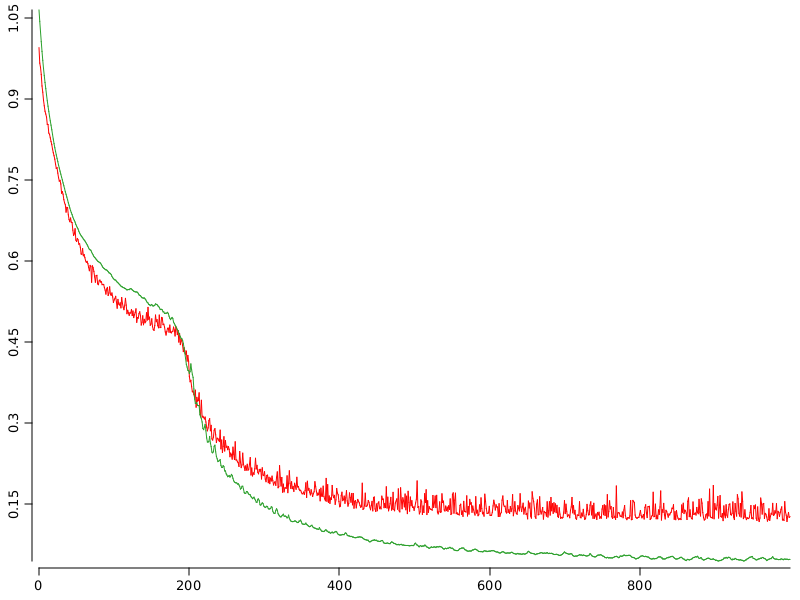

9b42ea43-eec0-4304-80ea-353241cb424d

In [22]:
display(WS.image(lines(trainLoss, color(Color.RED), lwd(1)).lines(testLoss, color(2), lwd(1))));